This notebook is based on Assoc. Prof. Kitsana Waiyamai's lecture, _"Data Classification & Decision Trees,"_
taught in 219333 course "Data Mining."

Python `import` Dance
=====================

Again, I need to import some stuff first..

In [2]:
from sympy import *
from math import *
from itertools import *
init_printing()

Inducing a Decision Tree
========================

Several algorithms exist for inducing a decision tree. Hunt's algorithm is one of the earliest.

- __Recursive partitioning__: recursively split the records into parts to achieve maximum homogeneity within the new parts.
- __Pruning the tree__: simplifying the tree by pruning branches to avoid overfitting.


Impurity
========

Let's assume that all records are in the same node.
Suppose that 50% of them are classified "good" and 50% of them are classified "bad."

_This is a bad node!_
Since if an unseen data end up here, we can't be certain that the result will be correct.
That's because 50% of training data in this node are good and 50% are bad.
Our induction will be as good as a coin flip.
This node is __impure__.

Now consider a node where all records are considered "good."
When an unseen data end up at this node,
we can be more confident that this data will also be a good one.

Partitioning 'Em
----------------

So what we want to do is this:
We want to partition the node, based on attribute values, into multiple parts.
Then, we measure each partition's impurity.
We combine the impurity values to obtain the split's impurity.
Reduction of impurity represents an __information gain__.

Since _there are multiple ways to split a node_ (e.g. by using different attributes),
we try different ways of splitting nodes,
and find which way of splitting produces the most information gain.
That's how we should split the node.

Measuring impurity has a lot to do with proportion of different classifications.
Here, we define a function to calculate the proportion from the number of items.

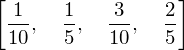

In [3]:
def proportions(f):
    total = sum(f)
    return [S(c) / total for c in f]

proportions([1, 2, 3, 4])

There are multiple ways of computing impurity.

GINI Index
----------

$$ GINI(t) = 1 - \sum_j{p(j \:|\: t) ^ 2} $$

In [4]:
def gini(f):
    return N(1 - sum(p ** 2 for p in proportions(f)))

In [5]:
print gini([0, 6])
print gini([1, 5])
print gini([2, 4])
print gini([3, 3])
print gini([1, 1, 1])
print gini([1, 1, 0])
print gini([1, 0, 0])

0
0.277777777777778
0.444444444444444
0.500000000000000
0.666666666666667
0.500000000000000
0


Entropy
-------

$$ Entropy(t) = -\sum_{j}p(j\:|\:t) \log p(j\:|\:t) $$

In [6]:
def entropy(f):
    return N(-sum(p * log(p, 2) if p > 0 else -0.0 for p in proportions(f)))

In [7]:
print entropy([0, 6])
print entropy([1, 5])
print entropy([2, 4])
print entropy([3, 3])
print entropy([1, 1, 1])
print entropy([1, 1, 0])
print entropy([1, 0, 0])

0
0.650022421648354
0.918295834054490
1.00000000000000
1.58496250072116
1.00000000000000
0


Let's Implement!
================

First, we list the raw data (from the slides).

In [8]:
raw_data = [
  'sunny hot high false N',
  'sunny hot high true N',
  'overcast hot high false P',
  'rain mild high false P',
  'rain cool normal false P',
  'rain cool normal true N',
  'overcast cool normal true P',
  'sunny mild high false N',
  'sunny cool normal false P',
  'rain mild normal false P',
  'sunny mild normal true P',
  'overcast mild high true P',
  'overcast hot normal false P',
  'rain mild high true N',
]

## Representing Records

We will represent the record as a 2-tuple.

- The first item contains the attribute values.
- The second item contains the classification result.

In [9]:
def to_record(text):
  (outlook, temperature, humidity,
    windy, classification) = text.split(' ')
  return ({
    'outlook': outlook,
    'temperature': temperature,
    'humidity': humidity,
    'windy': windy
  }, classification)

In [10]:
records = map(to_record, raw_data)
records[0]

({'humidity': 'high',
  'outlook': 'sunny',
  'temperature': 'hot',
  'windy': 'false'},
 'N')

Metrics
-------

Let's measure the proportion of the classification.

In [11]:
def data_frequency(data):
  return [
    sum(1 for (_, k) in data if k == 'P'),
    sum(1 for (_, k) in data if k == 'N')]

In [12]:
data_frequency(records)

In [13]:
def data_proportions(data):
  return proportions(data_frequency(data))

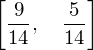

In [14]:
data_proportions(records)

Now, let's measure the impurity. We'll use GINI index in this case.

In [15]:
def data_impurity(data):
  return gini(data_proportions(data))

In [16]:
data_impurity(records)

Representing Trees
------------------

We'll write a simple class to represent a node.

In [17]:
class Tree:
  def __init__(self, data):
    self.data = data
    self.split = None
    self.children = None

In [18]:
root = Tree(records)

We also need a way of printing tree.

In [19]:
def print_tree(tree, label='(root)', prefix=''):
  if tree.split:
    print (prefix + label + ': ' + tree.split)
    for attr in tree.children:
      print_tree(tree.children[attr],
                 attr,
                 prefix + '  ')
  else:
    print (prefix + label + ': ' +
      '%s (%.3f)' % (data_frequency(tree.data),
                     data_impurity(tree.data)))

In [20]:
print_tree(root)

(root): [9, 5] (0.459)


Splitting Trees
---------------

Next, we want to be able to split the tree.
We don't worry about finding the best split yet.

In [21]:
def split_tree_by(tree, attr):
  tree.split = attr
  children = {}
  values = set(d[attr] for d, _ in tree.data)
  for value in values:
    children[value] = Tree([record
      for record in tree.data
        if record[0][attr] == value])
  tree.children = children

In [22]:
split_tree_by(root, 'outlook')
print_tree(root)

(root): outlook
  overcast: [4, 0] (0.000)
  sunny: [2, 3] (0.480)
  rain: [3, 2] (0.480)


Measuring Split Impurity
------------------------

Simply take the weighted average of the GINI index.


In [23]:
def split_impurity(tree):
  n = len(tree.data)
  total = 0
  for v, child in tree.children.iteritems():
    weight = S(len(child.data)) / n
    impurity = data_impurity(child.data)
    total += weight * impurity
  return total

In [24]:
split_impurity(root)

Calculating Information Gain
----------------------------

Again, information again is the reduction of impurity.

In [25]:
def split_gain(tree):
  baseline = data_impurity(tree.data)
  split = split_impurity(tree)
  return baseline - split

In [26]:
split_gain(root)

Selecting Best Attribute
------------------------

We try to split the tree using each attribute and take note of the impurity.

In [27]:
attributes = [
  'outlook', 'temperature',
  'humidity', 'windy']

for attr in attributes:
  split_tree_by(root, attr)
  gain = split_gain(root)
  print '%-15s %.3f' % (attr, gain)

outlook         0.116
temperature     0.019
humidity        0.092
windy           0.031


Here, we see that "outlook" is indeed the best split.
Here's the algorithm to find the best split attribute:

In [28]:
def try_split(tree, attr):
  split_tree_by(tree, attr)
  return split_gain(tree)
    
def best_split_attribute(tree):
  gain = lambda attr: try_split(tree, attr)
  return max(attributes, key=gain)

In [29]:
best_split_attribute(root)

'outlook'

Finally, the algorithm to split the tree using that best attribute.
Note that if the node is "pure", then we don't need further split.

In [30]:
def split_tree(tree):
  if data_impurity(tree.data) == 0:
    return False
  else:
    split_tree_by(tree,
      best_split_attribute(tree))
    return True

In [31]:
split_tree(root)

True

In [32]:
print_tree(root)

(root): outlook
  overcast: [4, 0] (0.000)
  sunny: [2, 3] (0.480)
  rain: [3, 2] (0.480)


Recursive Partitioning
----------------------

So we recursively split the tree until we can't split them anymore.

In [33]:
def recursive_split(tree):
  if split_tree(tree):
    for attr in tree.children:
      recursive_split(tree.children[attr])

In [34]:
recursive_split(root)

In [35]:
print_tree(root)

(root): outlook
  overcast: [4, 0] (0.000)
  sunny: humidity
    high: [0, 3] (0.000)
    normal: [2, 0] (0.000)
  rain: windy
    false: [3, 0] (0.000)
    true: [0, 2] (0.000)


Pruning
=======

Since I have only 1 hour left before the exam, I'll only describe briefly.

- __Pre-pruning__: stop splitting recursively, even if the node is impure.
  - number of instances too low (insignificant)
  - $\chi^2$ test
- __Post-pruning__: trim the nodes after the tree is fully grown.

Evaluation
==========

Given $TP$, $TN$, $FP$, $FN$

$$ \text{Accuracy} = \frac{TP+TN}{TP+TN+FP+FN} $$

$$ \text{TPR} = \frac{TP}{TP+FN} $$

TPR (true positive rate) is also known as _Sensitivity_ and _Recall_.

$$ \text{PPV} = \frac{TP}{TP+FP} $$

PPV (positive prediction value) is also known as _Precision_.